In [45]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [138]:
def read_results(n_ctx):
    with open('../../results/proportion_results_mlp_wine_%sctx.P' %(n_ctx), 'rb') as f:
        results = pickle.load(f)
    results = results['proportion_results']
    return results

In [139]:
def plot_pie_bar_chart(pies):
    n_ctx = pies.shape[0]
    n_hidd = pies.shape[1]
    ctxs = np.zeros(n_ctx+2) # ctxs[-1] refers to none, and ctxs[-2] to mixed

    for i in range(n_hidd):
        ctx = pies[:,i]
        if  not np.any(ctx):
            ctxs[-1]+=1
        elif np.sum(ctx)>1:
            ctxs[-2]+=1
        else:
            idx = np.where(ctx) # this finds which context is 1
            ctxs[idx]+=1
            
        
    labels = []
    for ctx in range(n_ctx):
        labels.append('ctx%s' %(ctx))
    labels.append('mixed')
    labels.append('none')
    fig, axs = plt.subplots(1,2)
    ax = axs[0]
    ax.pie(ctxs, labels=labels)#, autopct='%1.1f%%')#, shadow=True)#, startangle=90)
    ax.axis('equal')

    ax = axs[1]
    model = 'mlp'
    for ctx in range(ctxs.shape[0]):
        ax.bar(model, ctxs[ctx], bottom = np.sum(ctxs[:ctx]))
    ax.legend(labels)

    plt.tight_layout()

In [153]:
n_ctx=8
results = read_results(n_ctx)


In [154]:
if ctx==2:
    ps = results['ps']
    plt.scatter(ps[0], ps[1])
    plt.xlim([0,1])
    plt.ylim([0,1])

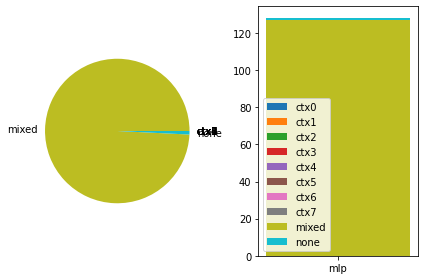

In [155]:
p_pies = np.asarray(results['p_pies'])    
plot_pie_bar_chart(p_pies)
# 

ipykernel_launcher:2: RuntimeWarning: invalid value encountered in greater


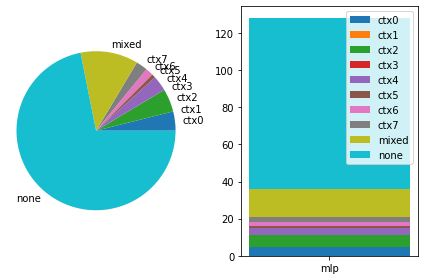

In [158]:
n = results['n']
f = n > 0.25
plot_pie_bar_chart(f)
# given the overall act for this hidd unit, the prop of trials that this unit was active was above 25%
# for a given unit, the prop of active trials for each context 

# normalized matrix

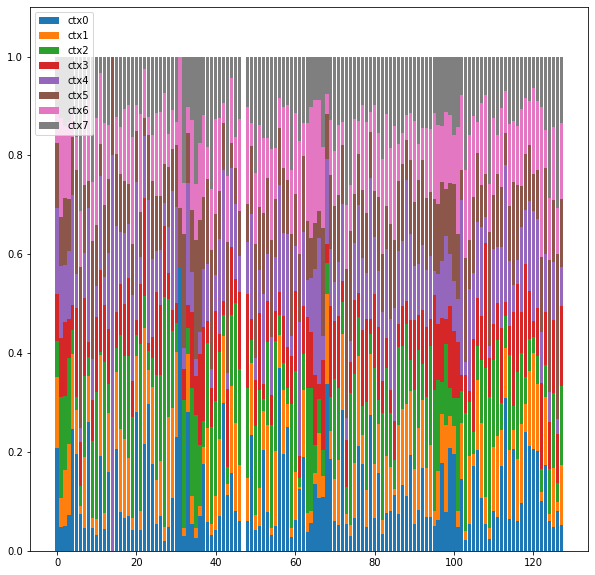

In [137]:
# plot 3P, using normalized p
fig, axs = plt.subplots(figsize=[10, 10])
hidd_dim = n.shape[1]
n_ctx = n.shape[0]

labels = []
ax = axs
for ctx in range(n_ctx):
    labels.append('ctx%s' %(ctx))
# for ctx in range(n_ctx):
#     if ctx>0:
#         ax.bar(np.arange(hidd_dim), n[ctx,:], bottom = np.sum(n[:ctx-1,:]))
#     else:
#         ax.bar(np.arange(hidd_dim), n[0,:])
# todo: sort the columns, based on the one context
ax.bar(np.arange(hidd_dim), n[0,:])
ax.bar(np.arange(hidd_dim), n[1,:], bottom = n[0,:])
if ((n_ctx==4) or (n_ctx==8)):
    ax.bar(np.arange(hidd_dim), n[2,:], bottom = n[0,:]+n[1,:])
    ax.bar(np.arange(hidd_dim), n[3,:], bottom = n[0,:]+n[1,:]+n[2,:])
if n_ctx==8:
    ax.bar(np.arange(hidd_dim), n[4,:], bottom = n[0,:]+n[1,:]+n[2,:]+n[3,:])
    ax.bar(np.arange(hidd_dim), n[5,:], bottom = n[0,:]+n[1,:]+n[2,:]+n[3,:]+ n[4,:])
    ax.bar(np.arange(hidd_dim), n[6,:], bottom = n[0,:]+n[1,:]+n[2,:]+n[3,:]+n[4,:]+n[5,:])
    ax.bar(np.arange(hidd_dim), n[7,:], bottom = n[0,:]+n[1,:]+n[2,:]+n[3,:]+n[4,:]+n[5,:]+n[6,:])

ax.set_ylim([0,1.1])
ax.legend(labels)

In [ ]:
# should duouble check
# should check the nans